In [1]:
!pip install mss
!pip install matplotlib
!pip install tensorboardX

## preparations

In [2]:
# debug
import time
import random
from IPython.display import clear_output
from matplotlib import pyplot as plt

### camera

In [3]:
from classes import GameEnv

game_env = GameEnv("snes9x.exe", "game - Snes9x 1.62.3", (100, 200, -10, -20))
camera = game_env.camera

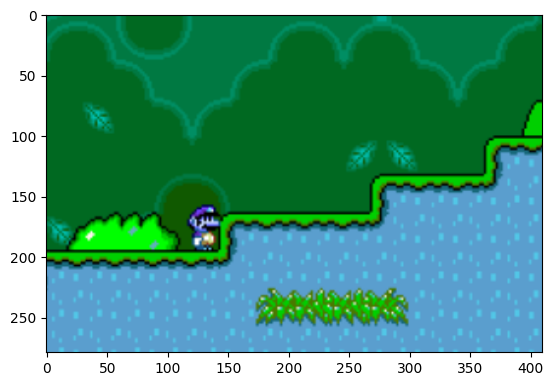

In [4]:
camera.set_foreground_game()
frame = camera.get_frame()
plt.imshow(frame)

### Agent

In [5]:
import torch
import torchvision

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [6]:
D = 200_000
GAMMA = 0.99
LR = 0.0001

NUM_EPISODES = 5000
SEQUENCE_LENGTH = 3
BATCH_SIZE = 8

EPS_NUM_STEPS = 10000
EPS_START = 0.6
EPS_END = 0.00001
EPS_DECAY = (EPS_START - EPS_END) / (EPS_NUM_STEPS)


action_space = 4

load_model = True
model_name = "2023_12_04_13_58_05"

In [7]:

from collections import deque
from itertools import islice
import random

CROP_DIMS = 60, 40, 95, 95
RESIZE = 150, 150

class Memory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque([], maxlen=capacity)
    
    def __len__(self):
        return len(self.memory)
    
    def push(self, experience):
        self.memory.append(experience)
    
    # for replay memory
    def sample(self, batch_size): # maybe separate by episode to avoid sequence where final_state -> start_state
        rand_range = random.randint(batch_size, len(self.memory))
        return list(islice(self.memory, rand_range - batch_size, rand_range))
    
    # for sequence
        
    def render(self):
        if len(self.memory) < SEQUENCE_LENGTH:
            return False, None
        x = torch.stack(tuple(self.memory))
        return True, x
    
    def clear(self):
        self.memory.clear()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(279, 410, 3)
(150, 150, 3)


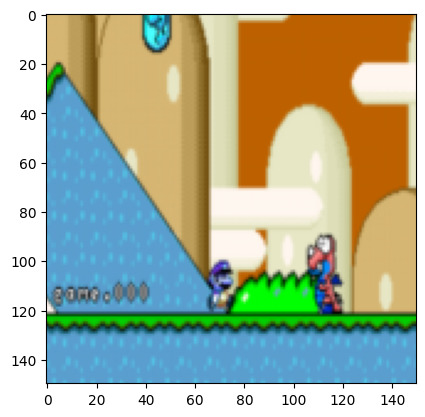

In [8]:
import math

def phi(observation):
    x = observation.transpose([2, 0, 1])
    x = torch.tensor(x, dtype=torch.float32, device=device)/255
    # x = torchvision.transforms.functional.crop(x, *CROP_DIMS)
    # x = torchvision.transforms.Grayscale()(x)
    x = torchvision.transforms.Resize(RESIZE, antialias=True)(x)
    # x = torchvision.transforms.Normalize(mean=x.mean(), std=x.std())(x)
    return x

def prompt_conv(x):
    print(x.shape)
    x = x[-1]
    if (len(x)) == 1 : return
    x = x.cpu().numpy()
    n = len(x)
    n = math.ceil(math.sqrt(n))
    f, axarr = plt.subplots(n,n, gridspec_kw={'wspace': 0, 'hspace': 0}, dpi=200)
    for i, img in enumerate(x):
        axarr[i // n, i % n].imshow(img, cmap='gray')
        
    for ax in axarr.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.show()


camera.set_foreground_game()
observation = game_env.reset()
print(observation.shape)
x = phi(observation).cpu().numpy().transpose([1,2,0])
print(x.shape)
plt.imshow(x)
plt.show()

In [9]:
def batch_images(batch):
    grid = torchvision.utils.make_grid(batch)
    grid = grid.cpu().numpy()
    plt.imshow(grid.transpose([1,2,0]))
    plt.show()
    
def forwad_batch_images(batch):
    batch = batch.unsqueeze(0)
    batch = batch.transpose(0,1)
    grid = torchvision.utils.make_grid(batch)
    grid = grid.cpu().detach().numpy()
    plt.imshow(grid.transpose([1,2,0]))
    plt.show()

In [10]:
import torch.nn as nn
import torch.nn.functional as F

lstm_n = 256
lstm_layers = 5

class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        # 3x40x40
        self.conv_0 = nn.Conv2d(3, 32, (3, 3), stride=1) # 3x37x37
        self.maxpool_0 = nn.MaxPool2d(2, stride=2)
        self.conv_1 = nn.Conv2d(32, 64, (3, 3), stride=1) # 4x6x6
        self.maxpool_1 = nn.MaxPool2d(2, stride=2)
        self.conv_2 = nn.Conv2d(64, 128, (3, 3), stride=1) # 4x6x6
        self.maxpool_2 = nn.MaxPool2d(2, stride=2)
        self.flatten = nn.Flatten() # 4x6x6
        
        self.lstm = nn.LSTM(36992, lstm_n, lstm_layers, batch_first=True)
        
        self.v = nn.Linear(lstm_n, 1)
        self.a = nn.Linear(lstm_n, action_space)
        
    def forward(self, x, hn, cn):
        batch_size = x.shape[0]
        x = x.reshape((-1, x.shape[-3], x.shape[-2], x.shape[-1]))
        x = F.relu(self.conv_0(x))
        x = self.maxpool_0(x)
        x = F.relu(self.conv_1(x))
        x = self.maxpool_1(x)
        x = F.relu(self.conv_2(x))
        x = self.maxpool_2(x)
        x = x.reshape((batch_size, -1, x.shape[-3], x.shape[-2], x.shape[-1]))
        x = torch.flatten(x, 2)
        #x = F.relu(self.fc1(x))
        x, (hn, cn) = self.lstm(x, (hn, cn))
        x = x[:,-1,:]
        a = self.a(x)
        v = self.v(x)
        q = v + a - a.mean()
        return q, hn, cn
    
    def forward_prompt(self, x, hn, cn):
        batch_size = x.shape[0]
        x = x.reshape((-1, x.shape[-3], x.shape[-2], x.shape[-1]))
        x = F.relu(self.conv_0(x))
        prompt_conv(x)
        x = self.maxpool_0(x)
        prompt_conv(x)
        x = F.relu(self.conv_1(x))
        prompt_conv(x)
        x = self.maxpool_1(x)
        prompt_conv(x)
        x = F.relu(self.conv_2(x))
        prompt_conv(x)
        x = self.maxpool_2(x)
        prompt_conv(x)
        x = x.reshape((batch_size, -1, x.shape[-3], x.shape[-2], x.shape[-1]))
        print(x.shape)
        x = torch.flatten(x, 2)
        print(x.shape)
        x, (hn, cn) = self.lstm(x, (hn, cn))
        print(x.shape)
        x = x[:,-1,:]
        print(x.shape)
        a = self.a(x)
        v = self.v(x)
        q = v + a - a.mean()
        print(q.shape)
        input("continue...")
        return q, hn, cn
    
    
    def q_train(self, target_net, optimizer, loss_fn, sequence):
        states, actions, rewards, next_states = *zip(*sequence), # let the ',' to not give syntax error
        

        states = states[:-1]
        actions = actions[:-1]
        rewards = rewards[1:]
        next_states = next_states[:-1]

        states = torch.stack(states)
        actions = torch.cat(actions)
        rewards = torch.cat(rewards)
        
        # next_states = torch.stack(next_states)
        non_final_states_mask = torch.tensor(tuple(map(lambda s: s is not None, next_states)), device=device)
        #non_final_next_states = next_states[non_final_states_mask]
        non_final_next_states = torch.stack([s for s in next_states if s is not None])


        batch_size = BATCH_SIZE - 1
        hn = torch.zeros(lstm_layers, batch_size, lstm_n, dtype=torch.float32, device=device) #requires gRAR?A?FAS?FAS?DSA
        cn = torch.zeros(lstm_layers, batch_size, lstm_n, dtype=torch.float32, device=device)
        max_action_qvalues = torch.zeros(batch_size, device=device)
        with torch.no_grad():
            non_final_next_states = non_final_next_states
            output = target_net(non_final_next_states, hn[:,non_final_states_mask], cn[:,non_final_states_mask])
            y, hn, cn = output
            y_max = y.max(1)[0]
            max_action_qvalues[non_final_states_mask] = y_max
            
        # Set yj for terminal and non-terminal phij+1
        y = rewards + GAMMA * max_action_qvalues
        
        hn = torch.zeros(lstm_layers, batch_size, lstm_n, dtype=torch.float32, device=device, requires_grad=True)
        cn = torch.zeros(lstm_layers, batch_size, lstm_n, dtype=torch.float32, device=device, requires_grad=True)
        qvalues, hn, cn = self(states, hn, cn)

            


        qvalues = qvalues.gather(1, actions)
        loss = loss_fn(qvalues, y.unsqueeze(1))
        optimizer.zero_grad()
        
        loss.backward()
        
        torch.nn.utils.clip_grad_value_(self.parameters(), 100)
        optimizer.step()
        
        return loss

In [11]:
import time
from itertools import count
from tensorboardX import SummaryWriter

timestr = time.strftime("%Y_%m_%d_%H_%M_%S")

# Initiliaze replay memory D to capacity N
replay_memory = Memory(D)
sequence = Memory(SEQUENCE_LENGTH)

# Initialize action-value function Q with random weights

policy_net = DQN().to(device) # used to store teta
target_net = DQN().to(device) # used to store teta-1

if load_model:
    policy_net.load_state_dict(torch.load(f'./saved_models/{model_name}/policy_net'))
    
target_net.load_state_dict(policy_net.state_dict())

optimizer = torch.optim.Adam(policy_net.parameters(), lr=LR)
loss_fn = nn.MSELoss()

steps = 0
episode = 0
epsilon = EPS_START

In [ ]:
time.sleep(2)
camera.set_foreground_game()
time.sleep(0.2)

with SummaryWriter(logdir="runs/"+timestr) as writer:
    
    while steps < D-50:
        
        ep_rewards = 0
        ep_qvalues = 0
        ep_loss = 0
        
        # Initialise sequence s1 = {x1} and preprocessed sequenced φ1 = φ(s1)
        observation = game_env.reset()
        state = phi(observation)
        last_reward = 0
        sequence.clear()
        sequence.push(state)
        
        rendered, sequence_state = sequence.render()
        
        for t in count():

            hn = torch.zeros(lstm_layers, 1, lstm_n, dtype=torch.float32, device=device)
            cn = torch.zeros(lstm_layers, 1, lstm_n, dtype=torch.float32, device=device)
            with torch.no_grad():
                if rendered:
                    q_value_action, hn, cn = policy_net(sequence_state.unsqueeze(0), hn, cn)
                    q_value_action = q_value_action.max(1)
                    ep_qvalues += q_value_action[0].item()
                else:
                    action = torch.tensor([[random.randint(0, action_space-1)]], device=device, dtype=torch.long)
                
            
            # With probability eps select a random action at
            epsilon = epsilon - EPS_DECAY if epsilon > EPS_END else EPS_END
            if random.uniform(0, 1) < epsilon:
                action = torch.tensor([[random.randint(0, action_space-1)]], device=device, dtype=torch.long)
            # otherwise select at = maxaQ*(phi(st), a; teta)
            else:
                if rendered:
                    action = q_value_action[1].view(1,1)
                    print(action)

            # Execute action at in emulator and observe reward rt and image xt+1
            observation, reward, game_over = game_env.step(action.item())
            
            ep_rewards += reward
            reward = torch.tensor([reward], device=device, dtype=torch.float32)

            # Set st+1 = st, at, xt+1 and preprocess phit+1 = phi(st+1)
            if game_over:
                next_state = None # ordem provavelmente errada
            else:
                next_state = phi(observation)
                sequence.push(next_state)
                rendered, next_sequence_state = sequence.render()

            if sequence_state != None:
                replay_memory.push((sequence_state, action, reward, next_sequence_state))
            
            if len(replay_memory) > BATCH_SIZE:
                loss = policy_net.q_train(target_net, optimizer, loss_fn, replay_memory.sample(BATCH_SIZE)).item()
                ep_loss += loss
                if t % 5 == 0:

                    clear_output(wait=True)
                    print('loss:', loss, 'step:', steps, 'epsilon:', epsilon, 'last_reward:', reward, 'ep:', episode)

                    ep_rewards = 0
                    ep_qvalues = 0
                    ep_loss = 0

                writer.add_scalar("Loss", ep_loss, steps)
                writer.add_scalar("Reward", ep_rewards, steps)
                writer.add_scalar("Qvalue", ep_qvalues, steps)
                writer.flush()
                
                if t % 1000 == 0:
                    target_net.load_state_dict(policy_net.state_dict())
                    
            sequence_state = next_sequence_state
            steps += 1
            if game_over:
                break
        """
        writer.add_scalar("Loss", ep_loss / t, episode)
        writer.add_scalar("Reward", ep_rewards / t, episode)[[]]
        writer.add_scalar("Qvalue", ep_qvalues / t, episode)
        """
        episode += 1
        # writer.flush()

torch.Size([3, 32, 148, 148])


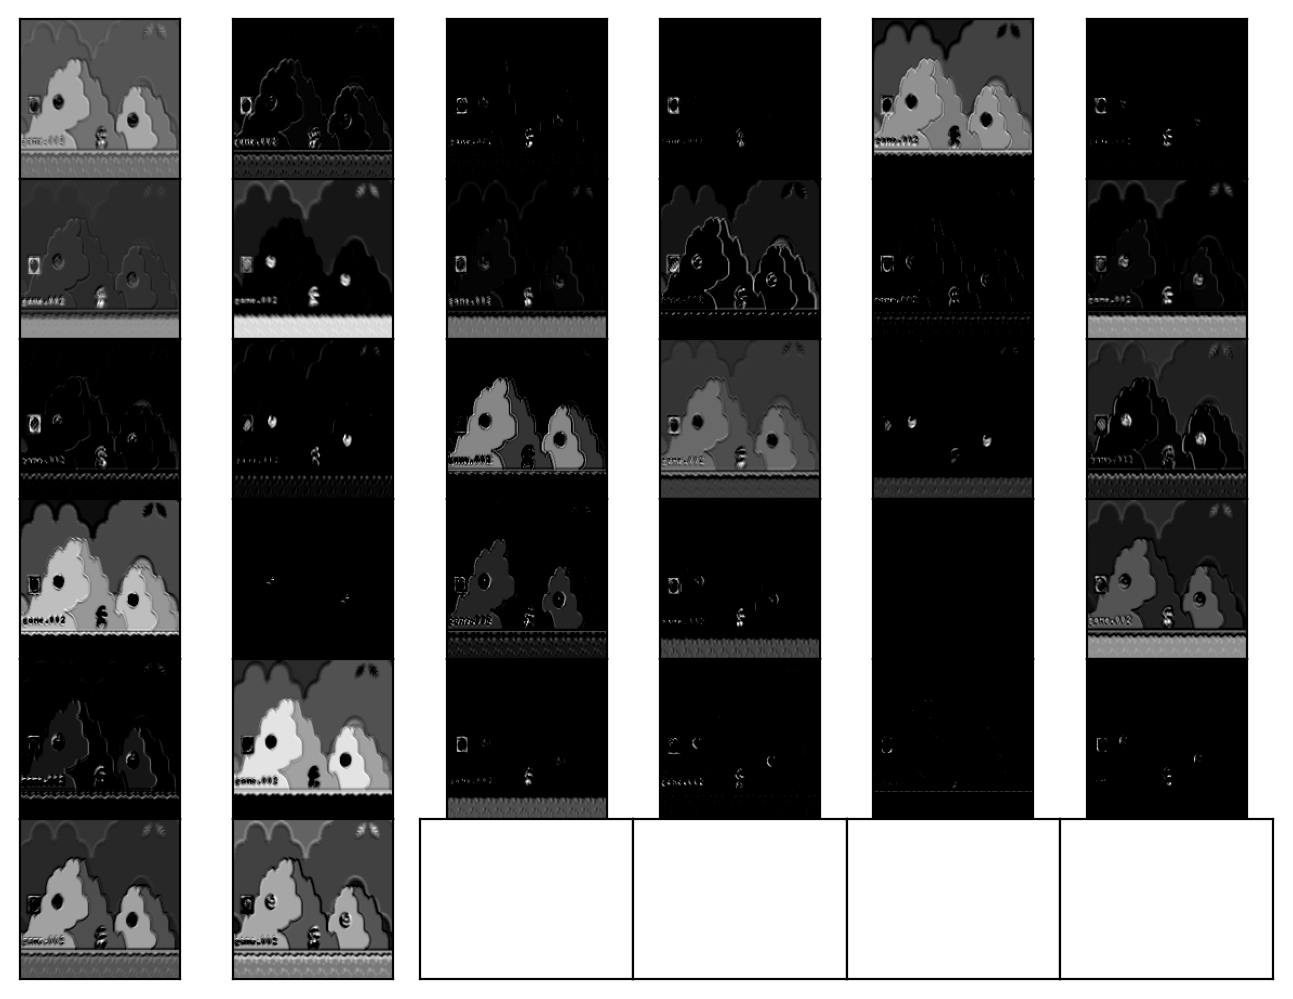

torch.Size([3, 32, 74, 74])


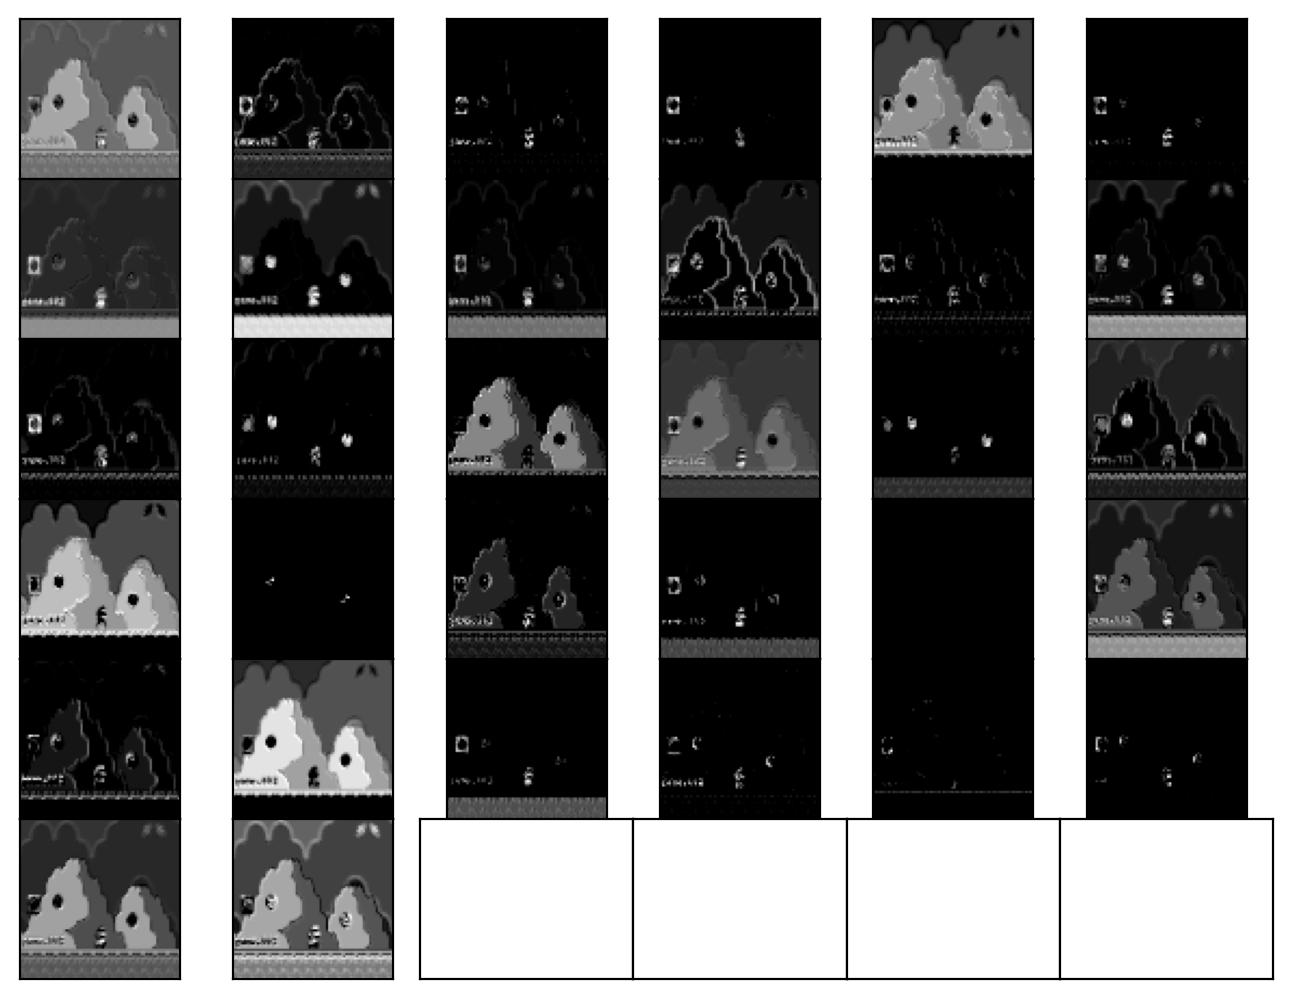

torch.Size([3, 64, 72, 72])


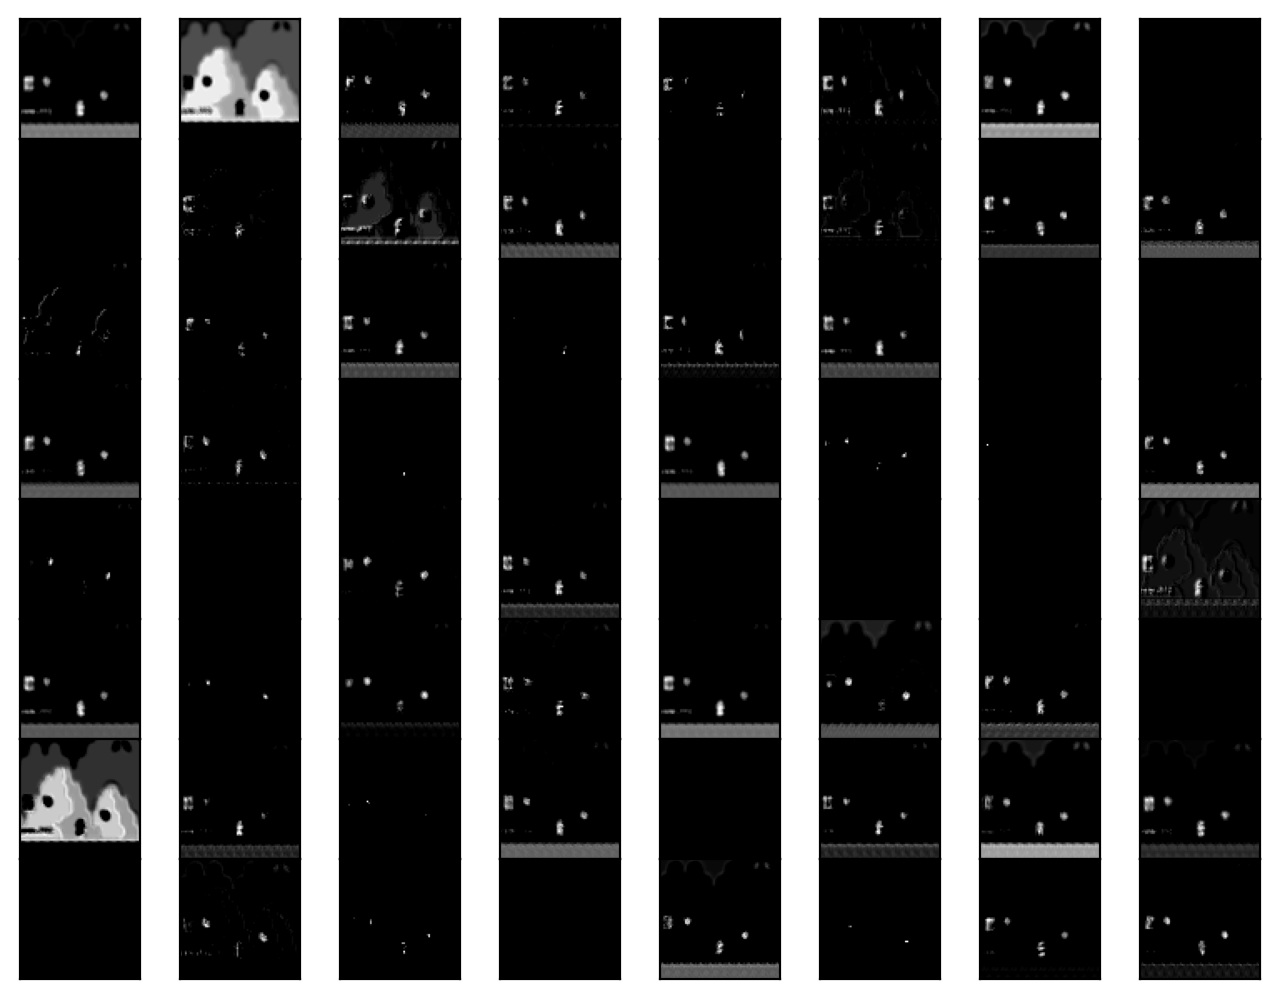

torch.Size([3, 64, 36, 36])


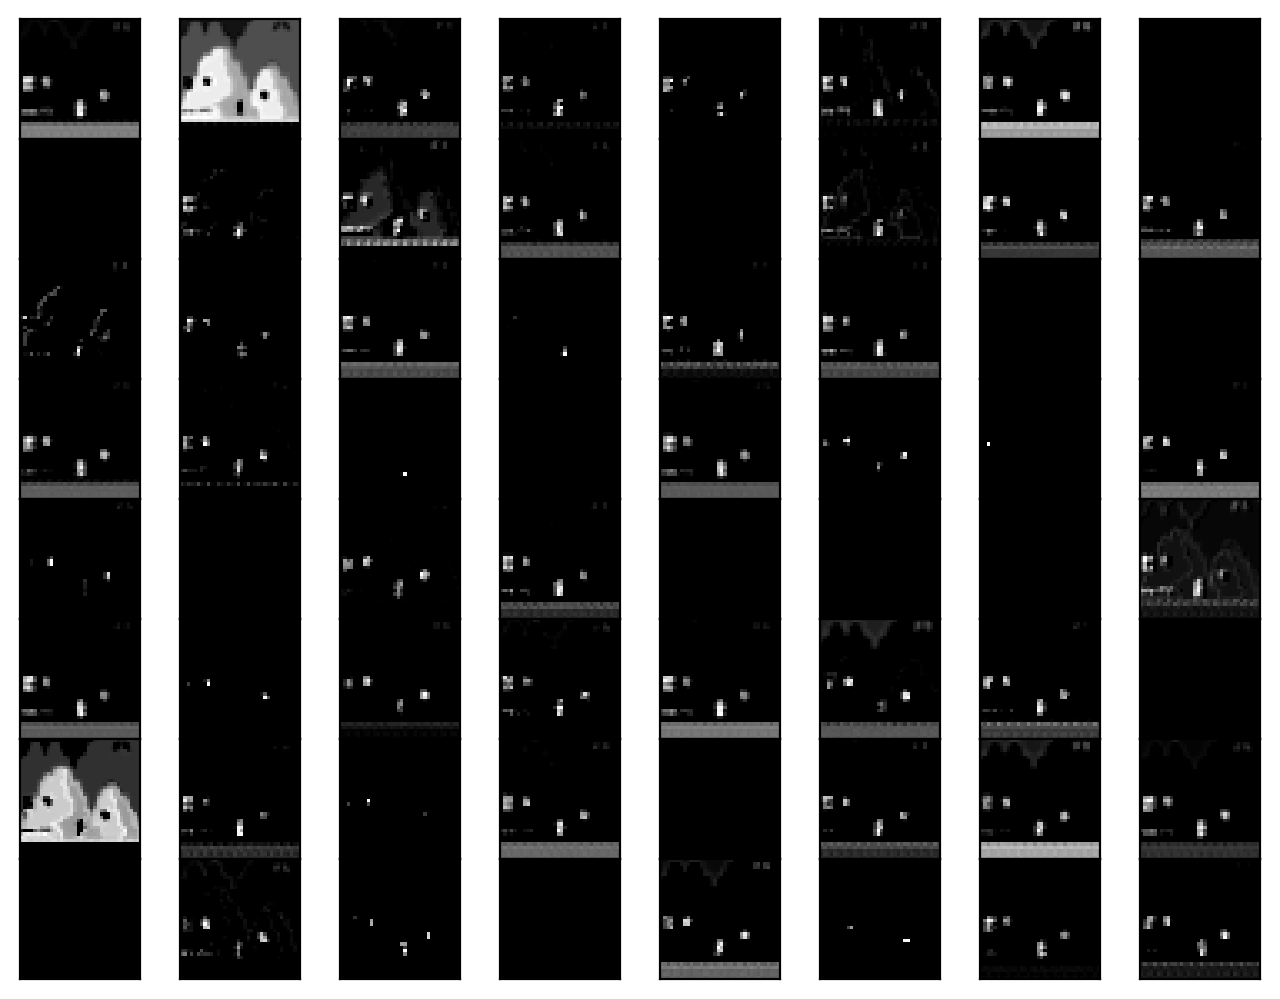

torch.Size([3, 128, 34, 34])


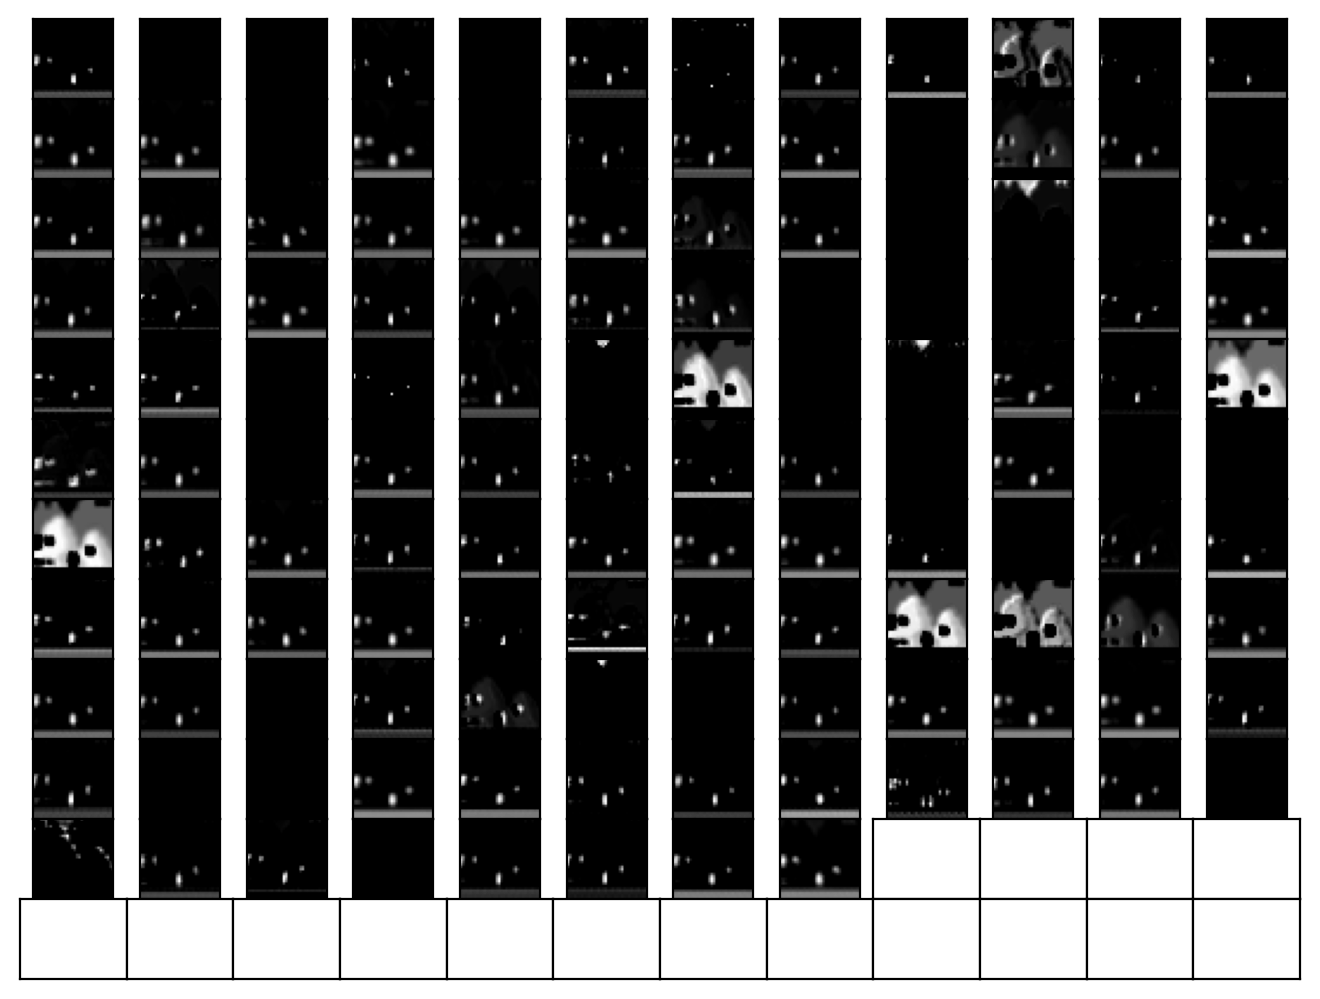

torch.Size([3, 128, 17, 17])


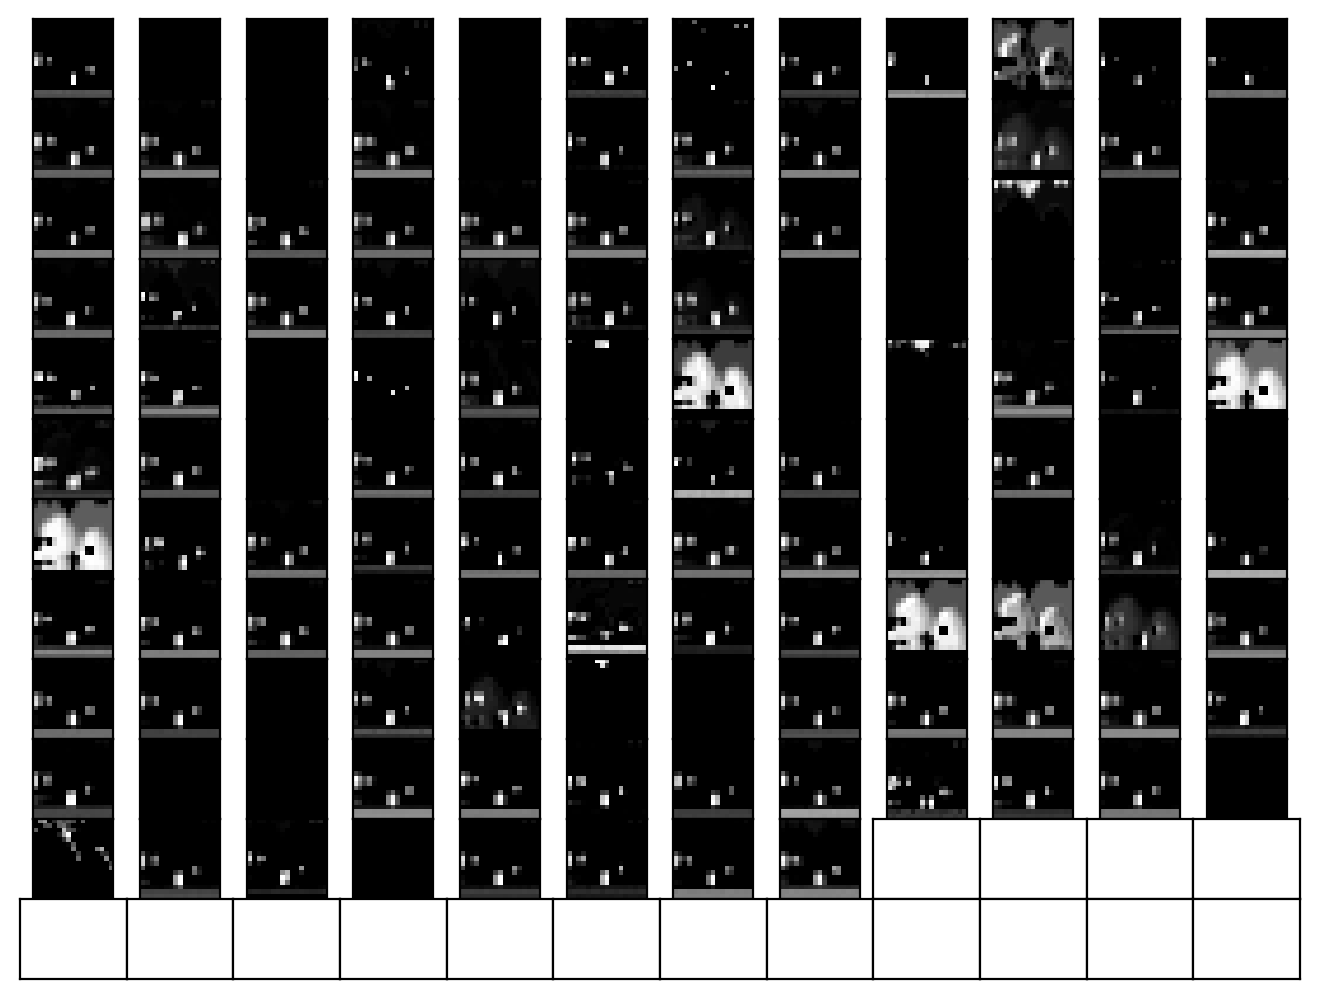

torch.Size([1, 3, 128, 17, 17])
torch.Size([1, 3, 36992])
torch.Size([1, 3, 256])
torch.Size([1, 256])
torch.Size([1, 4])


In [12]:
camera.set_foreground_game()
while True:
    
    observation = game_env.reset()
    time.sleep(0.1)
    state = phi(observation)
    sequence.clear()
    sequence.push(state)
    
    rendered, sequence_state = sequence.render()
    
    for t in count():

        hn = torch.zeros(lstm_layers, 1, lstm_n, dtype=torch.float32, device=device)
        cn = torch.zeros(lstm_layers, 1, lstm_n, dtype=torch.float32, device=device)
        with torch.no_grad():
            if rendered:
                q_value_action, hn, cn = policy_net.forward_prompt(sequence_state.unsqueeze(0), hn, cn)
                q_value_action = q_value_action.max(1)
                action = q_value_action[1].view(1,1)
            else:
                action = torch.tensor([[random.randint(0, action_space-1)]], device=device, dtype=torch.long)
        observation, reward, game_over = game_env.step(action.item())
        if game_over:
            next_state = None # ordem provavelmente errada
        else:
            next_state = phi(observation)
            sequence.push(next_state)
            rendered, next_sequence_state = sequence.render()
        sequence_state = next_sequence_state
        if game_over:
            break

In [ ]:

import os

save_model_dir = './saved_models'

if not os.path.exists(f'{save_model_dir}'):
    os.mkdir(f'{save_model_dir}')
if not os.path.exists(f'{save_model_dir}/{timestr}'):
    os.mkdir(f'{save_model_dir}/{timestr}')

torch.save(policy_net.state_dict(), f'{save_model_dir}/{timestr}/policy_net')
torch.save(target_net.state_dict(), f'{save_model_dir}/{timestr}/target_net')